#Критерии качества. Кривая ошибок. Оценивание качества.

1. Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.

2. Вычислить точность, полноту, специфичность.

3. Построить кривую ошибок и найти площадь под ней. Построить кривую "точность-полнота".

4. Разбить данные на обучающую и контрольную выборки. Построить ROC- кривую для каждой из подвыборок. Построить ROC- кривую на основе кроссвалидации (объединить прогнозы для разных фолдов).

5. Исследовать влияние выбора критерия обучения на AUC. Один из критериев — log loss, ещё один или два — на выбор. Как вариант: сравнить AdaBoost с градиентным бустингом.

6 (факультативно). Сбалансировать классы, используя веса для объектов выборки (подобрать веса так, чтобы суммарный вес каждого класса был одинаков). Решить задачу классификации (тем же методом, что и ранее), сравнить точность.

###1. Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.


In [ ]:
# 1) LOAD & PREPROCESS: filter tiny classes & reduce to binary
import pandas as pd
import numpy as np
from sklearn.utils import compute_class_weight

# Load raw data from CSV
data = pd.read_csv('creditcard.csv')

# Remove any classes with fewer than 50 samples for simplicity
counts = data['Class'].value_counts()
keep = counts[counts >= 50].index
data = data[data['Class'].isin(keep)]

# Convert to binary task: fraud (1) vs. non-fraud (0)
#(Here the dataset is already binary): =>
#   - Even though the dataset is already binary,
#   - this prepares for generalization => ensures no tiny classes exist if extended to multiclass.
data['BinaryClass'] = data['Class'].apply(lambda x: 1 if x == 1 else 0)

# Split features/target
X = data.drop(columns=['Class', 'BinaryClass'])
y = data['BinaryClass']

print("After filtering and mapping, class distribution:")
print(y.value_counts())

After filtering and mapping, class distribution:
BinaryClass
0    17836
1       81
Name: count, dtype: int64


###2. Вычислить точность, полноту, специфичность.


In [ ]:

# 2) BASELINE CLASSIFIER + CROSS-VALIDATED METRICS (no train/test split data here)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Define a baseline Random Forest (default settings, no weights)
clf = RandomForestClassifier(
    n_estimators=100,      # number of trees
    criterion='gini',      # splitting criterion (here is the default)
    class_weight=None,     # no class balancing yet
    random_state=42
)

# Use Stratified 5-fold CV to get robust predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # CV => cross-validation to avoid overfitting
y_pred_cv = cross_val_predict(clf, X, y, cv=cv, method='predict')

# Compute precision, recall, and specificity on CV predictions
precision = precision_score(y, y_pred_cv)  # how many predicted fraud were correct
recall    = recall_score(y, y_pred_cv)     # how many actual fraud were found
tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
specificity = tn / (tn + fp)               # true negative rate


#  Outputs baseline evaluation => using CV predictions.
print("Cross-validated metrics (baseline RF):")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")

Cross-validated metrics (baseline RF):
  Precision:   0.9459
  Recall:      0.8642
  Specificity: 0.9998


###3. Построить кривую ошибок и найти площадь под ней. Построить кривую "точность-полнота".

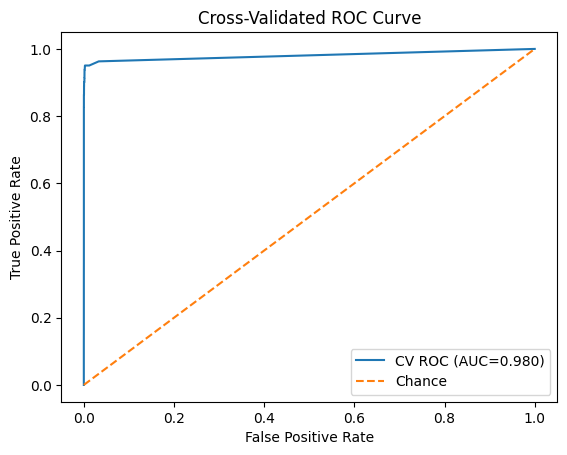

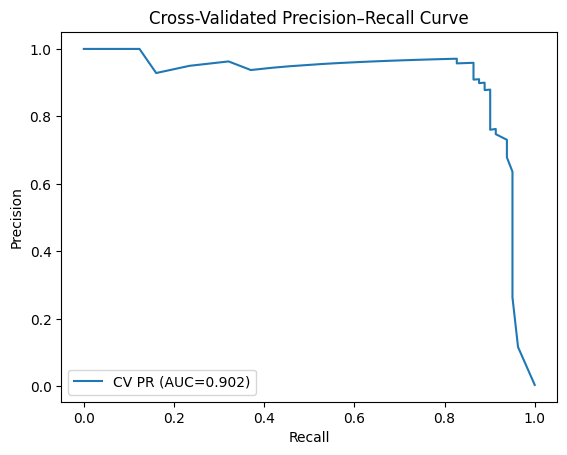

In [ ]:

# 3) ROC & Precision–Recall CURVES via CV (no train/test split)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtain probability scores via CV
#     We Get probabilities for class 1 for ROC/PR curves => using CV, Needed to draw ROC and PR curves (which use scores, not hard predictions)
y_score_cv = cross_val_predict(
    clf, X, y, cv=cv, method='predict_proba'
)[:, 1]  # probability of class 1

# Plot ROC curve over all CV folds
fpr, tpr, _ = roc_curve(y, y_score_cv)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'CV ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curve')
plt.legend()
plt.show()

# Plot Precision–Recall curve over all CV folds
prec, rec, _ = precision_recall_curve(y, y_score_cv)
pr_auc = average_precision_score(y, y_score_cv)

plt.figure()
plt.plot(rec, prec, label=f'CV PR (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cross-Validated Precision–Recall Curve')
plt.legend()
plt.show()


###4. Разбить данные на обучающую и контрольную выборки. Построить ROC- кривую для каждой из подвыборок. Построить ROC- кривую на основе кроссвалидации (объединить прогнозы для разных фолдов).

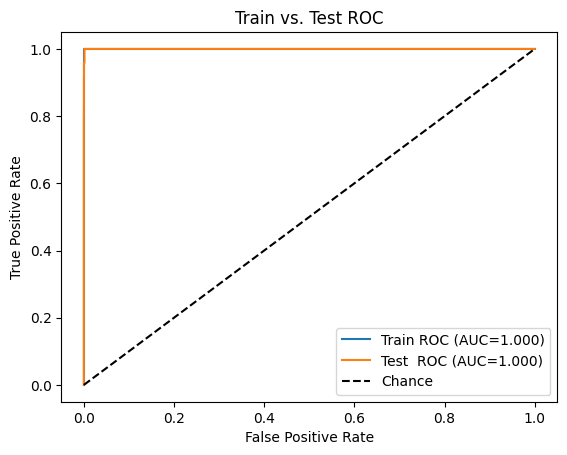

In [ ]:
# 4) TRAIN/TEST SPLIT + ROC per subset

from sklearn.model_selection import train_test_split

# Now split into separate train/test sets (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit the baseline RF on the training data
clf.fit(X_train, y_train)

# Compute ROC curves on both subsets
y_train_prob = clf.predict_proba(X_train)[:, 1]    #[:, 1] => take the probability of the positive class (fraud class here).
y_test_prob  = clf.predict_proba(X_test)[:, 1]

# FPR => (False Positive Rate)
# TPR => (True Positive Rate)
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_prob)
fpr_te, tpr_te, _ = roc_curve(y_test,  y_test_prob)


#Compute AUC (Area Under Curve)
# Higher AUC => better model.
auc_tr = auc(fpr_tr, tpr_tr)  # AUC on training set
auc_te = auc(fpr_te, tpr_te)  # AUC on test set

plt.figure()
plt.plot(fpr_tr, tpr_tr, label=f'Train ROC (AUC={auc_tr:.3f})')
plt.plot(fpr_te, tpr_te, label=f'Test  ROC (AUC={auc_te:.3f})')
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train vs. Test ROC')
plt.legend()
plt.show()

###5. Исследовать влияние выбора критерия обучения на AUC. Один из критериев — log loss, ещё один или два — на выбор. Как вариант: сравнить AdaBoost с градиентным бустингом.

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# 1) Random Forest with different splitting criteria
for crit in ['gini', 'entropy']:
    rf = RandomForestClassifier(
        n_estimators=100,
        criterion=crit,
        random_state=42
    )
    rf.fit(X_train, y_train)
    auc_val = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
    print(f"RF criterion={crit:7s} → AUC = {auc_val:.4f}")

# 2) Gradient Boosting with valid loss functions
for loss in ['log_loss', 'exponential']:
    gb = GradientBoostingClassifier(
        loss=loss,
        n_estimators=100,
        random_state=42
    )
    gb.fit(X_train, y_train)
    auc_val = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
    print(f"GB loss={loss:10s} → AUC = {auc_val:.4f}")

# 3) AdaBoost vs. Gradient Boosting (using log_loss)
ada = AdaBoostClassifier(
    n_estimators=100,
    random_state=42
)
gb_log = GradientBoostingClassifier(
    loss='log_loss',
    n_estimators=100,
    random_state=42
)

ada.fit(X_train, y_train)
gb_log.fit(X_train, y_train)

ada_auc    = roc_auc_score(y_test, ada.predict_proba(X_test)[:, 1])
gb_log_auc = roc_auc_score(y_test, gb_log.predict_proba(X_test)[:, 1])
print(f"AdaBoost AUC:      {ada_auc:.4f}")
print(f"GB (log_loss) AUC: {gb_log_auc:.4f}")

# 4) Random Forest with balanced class weights
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, weights))

rf_bal = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42
)
rf_bal.fit(X_train, y_train)
balanced_auc = roc_auc_score(y_test, rf_bal.predict_proba(X_test)[:, 1])
print(f"RF with balanced weights → AUC = {balanced_auc:.4f}")


RF criterion=gini    → AUC = 0.9999
RF criterion=entropy → AUC = 0.9999
GB loss=log_loss   → AUC = 0.9991
GB loss=exponential → AUC = 0.9998
AdaBoost AUC:      0.9998
GB (log_loss) AUC: 0.9991
RF with balanced weights → AUC = 0.9999


###6 (факультативно). Сбалансировать классы, используя веса для объектов выборки (подобрать веса так, чтобы суммарный вес каждого класса был одинаков). Решить задачу классификации (тем же методом, что и ранее), сравнить точность.

In [ ]:

# 6) BALANCE CLASSES VIA SAMPLE WEIGHTS & COMPARE ACCURACY

from sklearn.metrics import accuracy_score

# Predict on test set with the original (unweighted) RF
y_pred_unweighted = clf.predict(X_test)

# Predict on test set with the weighted RF (rf_bal from block 5)
y_pred_weighted   = rf_bal.predict(X_test)

# Compute accuracy for both
acc_unweighted = accuracy_score(y_test, y_pred_unweighted)
acc_weighted   = accuracy_score(y_test, y_pred_weighted)

print(f'Accuracy (unweighted RF): {acc_unweighted:.4f}')
print(f'Accuracy (balanced-weights RF): {acc_weighted:.4f}')

Accuracy (unweighted RF): 0.9993
Accuracy (balanced-weights RF): 0.9991
